# Description

- Evaluate multiple runs from DAG modeling pipelines
- Calculate top-level stats and adjust for multiple hypothesis testing

# Imports

In [27]:
%load_ext autoreload
%autoreload 2


import pandas as pd

import automl.notebooks.utils as amlnut
import core.config as cfg
import core.config_builders as cfgb
import core.plotting as plot
import core.statistics as stats
import core.timeseries_study as tss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load config

In [2]:
eval_config = cfgb.get_config_from_env()

In [3]:
# if eval_config is None:
if True:
    eval_config = cfgb.get_config_from_nested_dict(
        {
            "results_directory": "/data/automl/experiments/basf/RH_1",
            "metrics": {
                "perf_": stats.compute_annualized_sharpe_ratio,
                "ttest_": stats.ttest_1samp,
                "moments_": stats.compute_moments,
            },
            "perform_global_adj": {"pval_col": "ttest_pval",},
            "global_adj_pval_threshold": 0.2,
            "perform_family_adj": {"pval_col": "ttest_pval", "tag_col": "tag",},
            "perform_family_selection": {
                "tag_col": "tag",
                "sr_col": "perf_ann_sharpe",
                "adj_pval_threshold": 0.2,
                "ann_sharpe_threshold": 0.7,
                "num": 10,
            },
            "tags": (
                "rh1",
                "rh2",
                "rh3",
                "rh4",
                "rh5",
                "rh6",
                "rh7",
                "rh8",
                "rh9",
                "rh10",
                "rh11",  # Selected (Propylene)
                "rh12",
                "rh13",  # Selected (Butadiene)
                "rh14",
                "rh15",  # Selected (Butadiene)
                "butadiene",
            ),
            "pipeline_stages_to_plot": {
                "sig/load_data",
                "sig/dropna",
                "rets/clip",
                "model/ml",
            },
        }
    )

In [4]:
eval_config

results_directory: /data/automl/experiments/basf/RH_1
metrics:
  perf_: <function compute_annualized_sharpe_ratio>
  ttest_: <function ttest_1samp>
  moments_: <function compute_moments>
perform_global_adj:
  pval_col: ttest_pval
global_adj_pval_threshold: 0.2
perform_family_adj:
  pval_col: ttest_pval
  tag_col: tag
perform_family_selection:
  tag_col: tag
  sr_col: perf_ann_sharpe
  adj_pval_threshold: 0.2
  ann_sharpe_threshold: 0.7
  num: 10
tags: ('rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8', 'rh9', 'rh10', 'rh11', 'rh12', 'rh13', 'rh14', 'rh15', 'butadiene')
pipeline_stages_to_plot: {'sig/dropna', 'model/ml', 'rets/clip', 'sig/load_data'}

# Load pipeline run configs

In [5]:
# Load configs before loading (larger) result_bundles.
config_dict = amlnut.load_files(eval_config["results_directory"], "config.pkl")

In [6]:
# Create config dataframe.
configs = cfg.convert_to_dataframe(config_dict.values())

In [7]:
configs.head(3)

,tag,DAG.rets/read_price_data.source_node_name,DAG.rets/read_price_data.source_node_kwargs.source_code,DAG.rets/read_price_data.source_node_kwargs.dataset_code,DAG.rets/read_price_data.source_node_kwargs.payload_code,DAG.rets/read_price_data.source_node_kwargs.end_date,DAG.rets/process_outliers.col_mode,DAG.rets/process_outliers.transformer_kwargs.mode,DAG.rets/process_outliers.transformer_kwargs.lower_quantile,DAG.rets/process_outliers.transformer_kwargs.window,...,DAG.sig/dropna,DAG.model/ml.steps_ahead,DAG.model/ml.model_func,DAG.model/ml.y_vars,DAG.model/ml.x_vars,DAG.model/ml.model_kwargs.fit_intercept,meta.dag_builder,meta.result_dir,meta.id,meta.experiment_result_dir
0,rh1,wind,,,S5425051,2018,replace_all,winsorize,0.01,252,...,{},1,<class 'sklearn.linear_model._base.LinearRegre...,[zret_0],"[S0070156, S5426781]",False,<dataflow_p1.task2561_pipeline.ReturnsPredicti...,/data/automl/experiments/basf/RH_1,0,/data/automl/experiments/basf/RH_1/result_0
1,rh1,wind,,,S5425051,2018,replace_all,winsorize,0.01,252,...,{},1,<class 'sklearn.linear_model._base.LinearRegre...,[zret_0],"[S0070156, S5426781]",False,<dataflow_p1.task2561_pipeline.ReturnsPredicti...,/data/automl/experiments/basf/RH_1,1,/data/automl/experiments/basf/RH_1/result_1
2,rh1,wind,,,S5425051,2018,replace_all,winsorize,0.01,252,...,{},1,<class 'sklearn.linear_model._base.LinearRegre...,[zret_0],"[S0070156, S5426781]",False,<dataflow_p1.task2561_pipeline.ReturnsPredicti...,/data/automl/experiments/basf/RH_1,2,/data/automl/experiments/basf/RH_1/result_2


In [8]:
# Create dataframe of config diffs.
diffs = cfg.diff_configs(config_dict.values())
config_diffs = cfg.convert_to_dataframe(diffs).dropna(how="all", axis=1)

In [9]:
config_diffs.head(3)

,tag,DAG.rets/read_price_data.source_node_kwargs.payload_code,DAG.rets/resample.rule,DAG.sig/load_data.payload_codes,DAG.sig/resample.rule,DAG.sig/add_lags.method_kwargs.periods,DAG.sig/compute_smooth_moving_average.transformer_kwargs.tau,DAG.sig/compute_smooth_moving_average.transformer_kwargs.max_depth,DAG.sig/zscore.transformer_kwargs.tau,DAG.model/ml.x_vars,meta.dag_builder,meta.id,meta.experiment_result_dir
0,rh1,S5425051,W,"[S0070156, S5426781]",W,4,2,1,2,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,0,/data/automl/experiments/basf/RH_1/result_0
1,rh1,S5425051,W,"[S0070156, S5426781]",W,4,2,1,4,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,1,/data/automl/experiments/basf/RH_1/result_1
2,rh1,S5425051,W,"[S0070156, S5426781]",W,4,2,1,8,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,2,/data/automl/experiments/basf/RH_1/result_2


# Load pipeline result bundles

In [10]:
result_bundles = amlnut.load_files(
    eval_config["results_directory"], "result_bundle.pkl"
)

In [11]:
len(result_bundles)

4896

# Calculate metrics and performance statistics

In [12]:
pnls = amlnut.compute_pnl_v2(result_bundles)

In [13]:
# TODO: Add a progress bar.
pnl_stats = tss.map_dict_to_dataframe(
    pnls, eval_config["metrics"].to_dict()
).transpose()

/wd/dima/commodity_research/amp/core/finance.py:318: RuntimeWarning: invalid value encountered in double_scalars
  sr = log_rets.mean() / log_rets.std()


In [14]:
pnl_stats.head(3)

,perf_ann_sharpe,perf_ann_sharpe_se,ttest_tval,ttest_pval,moments_mean,moments_std,moments_skew,moments_kurtosis
0,0.437339,0.052468,1.209925,0.227028,0.005449,0.089852,0.334719,18.073834
1,0.256548,0.050944,0.709755,0.478273,0.001960,0.055093,1.451462,29.880921
2,0.241849,0.050853,0.669089,0.503828,0.001649,0.049165,2.553386,28.624280


## Global adjustment

In [15]:
pnl_stats_with_adj = amlnut.perform_global_adj(
    pnl_stats, **eval_config["perform_global_adj"].to_dict()
)

In [16]:
pnl_stats_with_adj

,perf_ann_sharpe,perf_ann_sharpe_se,ttest_tval,ttest_pval,moments_mean,moments_std,moments_skew,moments_kurtosis,global_adj_pval
0,0.437339,0.052468,1.209925,0.227028,0.005449,0.089852,0.334719,18.073834,0.355231
1,0.256548,0.050944,0.709755,0.478273,0.001960,0.055093,1.451462,29.880921,0.557954
2,0.241849,0.050853,0.669089,0.503828,0.001649,0.049165,2.553386,28.624280,0.576147
3,0.396306,0.052056,1.096403,0.273567,0.004568,0.083127,0.541993,20.865001,0.397162
4,0.220550,0.050731,0.610164,0.542102,0.001482,0.048448,2.033791,34.043340,0.607013
...,...,...,...,...,...,...,...,...,...
4891,0.771240,0.129805,1.953639,0.054424,0.032741,0.147060,0.439014,0.812976,0.142709
4892,0.929530,0.136373,2.354605,0.021126,0.049306,0.183752,0.510950,0.833226,0.082437
4893,0.577719,0.123103,1.463429,0.147474,0.023521,0.141034,0.426989,0.710542,0.265105
4894,0.878924,0.134176,2.226414,0.028949,0.040947,0.161386,0.362052,0.252377,0.099218


In [17]:
results_df = pd.concat([pnl_stats_with_adj, config_diffs], axis=1)

In [18]:
results_df.head()

,perf_ann_sharpe,perf_ann_sharpe_se,ttest_tval,ttest_pval,moments_mean,moments_std,moments_skew,moments_kurtosis,global_adj_pval,tag,...,DAG.sig/load_data.payload_codes,DAG.sig/resample.rule,DAG.sig/add_lags.method_kwargs.periods,DAG.sig/compute_smooth_moving_average.transformer_kwargs.tau,DAG.sig/compute_smooth_moving_average.transformer_kwargs.max_depth,DAG.sig/zscore.transformer_kwargs.tau,DAG.model/ml.x_vars,meta.dag_builder,meta.id,meta.experiment_result_dir
0,0.437339,0.052468,1.209925,0.227028,0.005449,0.089852,0.334719,18.073834,0.355231,rh1,...,"[S0070156, S5426781]",W,4,2,1,2,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,0,/data/automl/experiments/basf/RH_1/result_0
1,0.256548,0.050944,0.709755,0.478273,0.001960,0.055093,1.451462,29.880921,0.557954,rh1,...,"[S0070156, S5426781]",W,4,2,1,4,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,1,/data/automl/experiments/basf/RH_1/result_1
2,0.241849,0.050853,0.669089,0.503828,0.001649,0.049165,2.553386,28.624280,0.576147,rh1,...,"[S0070156, S5426781]",W,4,2,1,8,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,2,/data/automl/experiments/basf/RH_1/result_2
3,0.396306,0.052056,1.096403,0.273567,0.004568,0.083127,0.541993,20.865001,0.397162,rh1,...,"[S0070156, S5426781]",W,4,2,2,2,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,3,/data/automl/experiments/basf/RH_1/result_3
4,0.220550,0.050731,0.610164,0.542102,0.001482,0.048448,2.033791,34.043340,0.607013,rh1,...,"[S0070156, S5426781]",W,4,2,2,4,"[S0070156, S5426781]",<dataflow_p1.task2561_pipeline.ReturnsPredicti...,4,/data/automl/experiments/basf/RH_1/result_4


AttributeError: 'AxesSubplot' object has no attribute 'flatten'

<Figure size 720x1152 with 0 Axes>

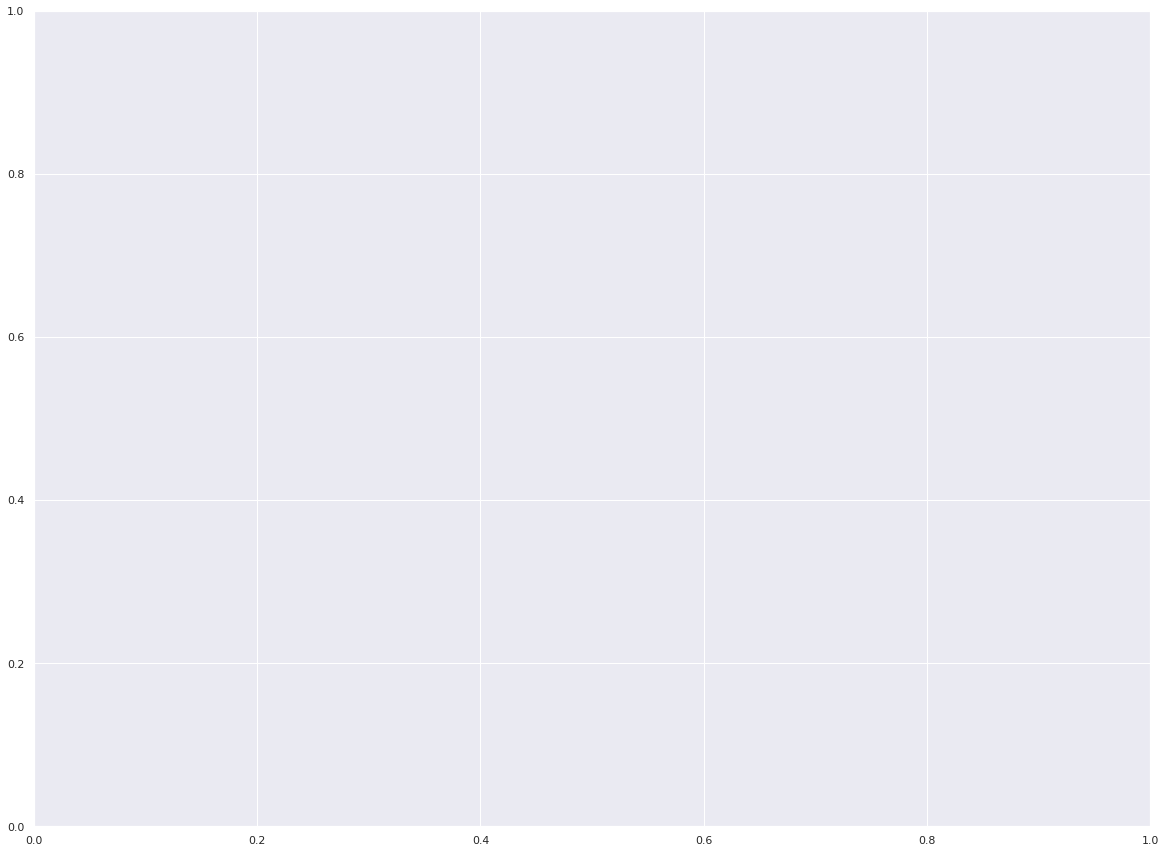

In [21]:
plot.multipletests_plot(
    results_df["global_adj_pval"].dropna(),
    threshold=eval_config["global_adj_pval_threshold"],
)

## Family-wise adjustment

In [22]:
results_df = amlnut.perform_family_adj(
    results_df, **eval_config["perform_family_adj"].to_dict()
)

In [23]:
results_df.columns

Index(['perf_ann_sharpe', 'perf_ann_sharpe_se', 'ttest_tval', 'ttest_pval',
       'moments_mean', 'moments_std', 'moments_skew', 'moments_kurtosis',
       'global_adj_pval', 'tag',
       'DAG.rets/read_price_data.source_node_kwargs.payload_code',
       'DAG.rets/resample.rule', 'DAG.sig/load_data.payload_codes',
       'DAG.sig/resample.rule', 'DAG.sig/add_lags.method_kwargs.periods',
       'DAG.sig/compute_smooth_moving_average.transformer_kwargs.tau',
       'DAG.sig/compute_smooth_moving_average.transformer_kwargs.max_depth',
       'DAG.sig/zscore.transformer_kwargs.tau', 'DAG.model/ml.x_vars',
       'meta.dag_builder', 'meta.id', 'meta.experiment_result_dir',
       'rh1_adj_pval', 'rh2_adj_pval', 'rh3_adj_pval', 'rh4_adj_pval',
       'rh5_adj_pval', 'rh6_adj_pval', 'rh7_adj_pval', 'rh8_adj_pval',
       'rh9_adj_pval', 'rh10_adj_pval', 'rh11_adj_pval', 'rh12_adj_pval',
       'rh13_adj_pval', 'rh14_adj_pval', 'rh15_adj_pval'],
      dtype='object')

In [24]:
results_df.head(3)

,perf_ann_sharpe,perf_ann_sharpe_se,ttest_tval,ttest_pval,moments_mean,moments_std,moments_skew,moments_kurtosis,global_adj_pval,tag,...,rh6_adj_pval,rh7_adj_pval,rh8_adj_pval,rh9_adj_pval,rh10_adj_pval,rh11_adj_pval,rh12_adj_pval,rh13_adj_pval,rh14_adj_pval,rh15_adj_pval
0,0.437339,0.052468,1.209925,0.227028,0.005449,0.089852,0.334719,18.073834,0.355231,rh1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.256548,0.050944,0.709755,0.478273,0.001960,0.055093,1.451462,29.880921,0.557954,rh1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.241849,0.050853,0.669089,0.503828,0.001649,0.049165,2.553386,28.624280,0.576147,rh1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#For some reasons there is no _adj_pval for 'butadiene'. Might need tfixing
adj_cols = []
for tag in eval_config["tags"][:-1]:
    adj_cols.append(tag + "_adj_pval")

<Figure size 2160x3456 with 0 Axes>

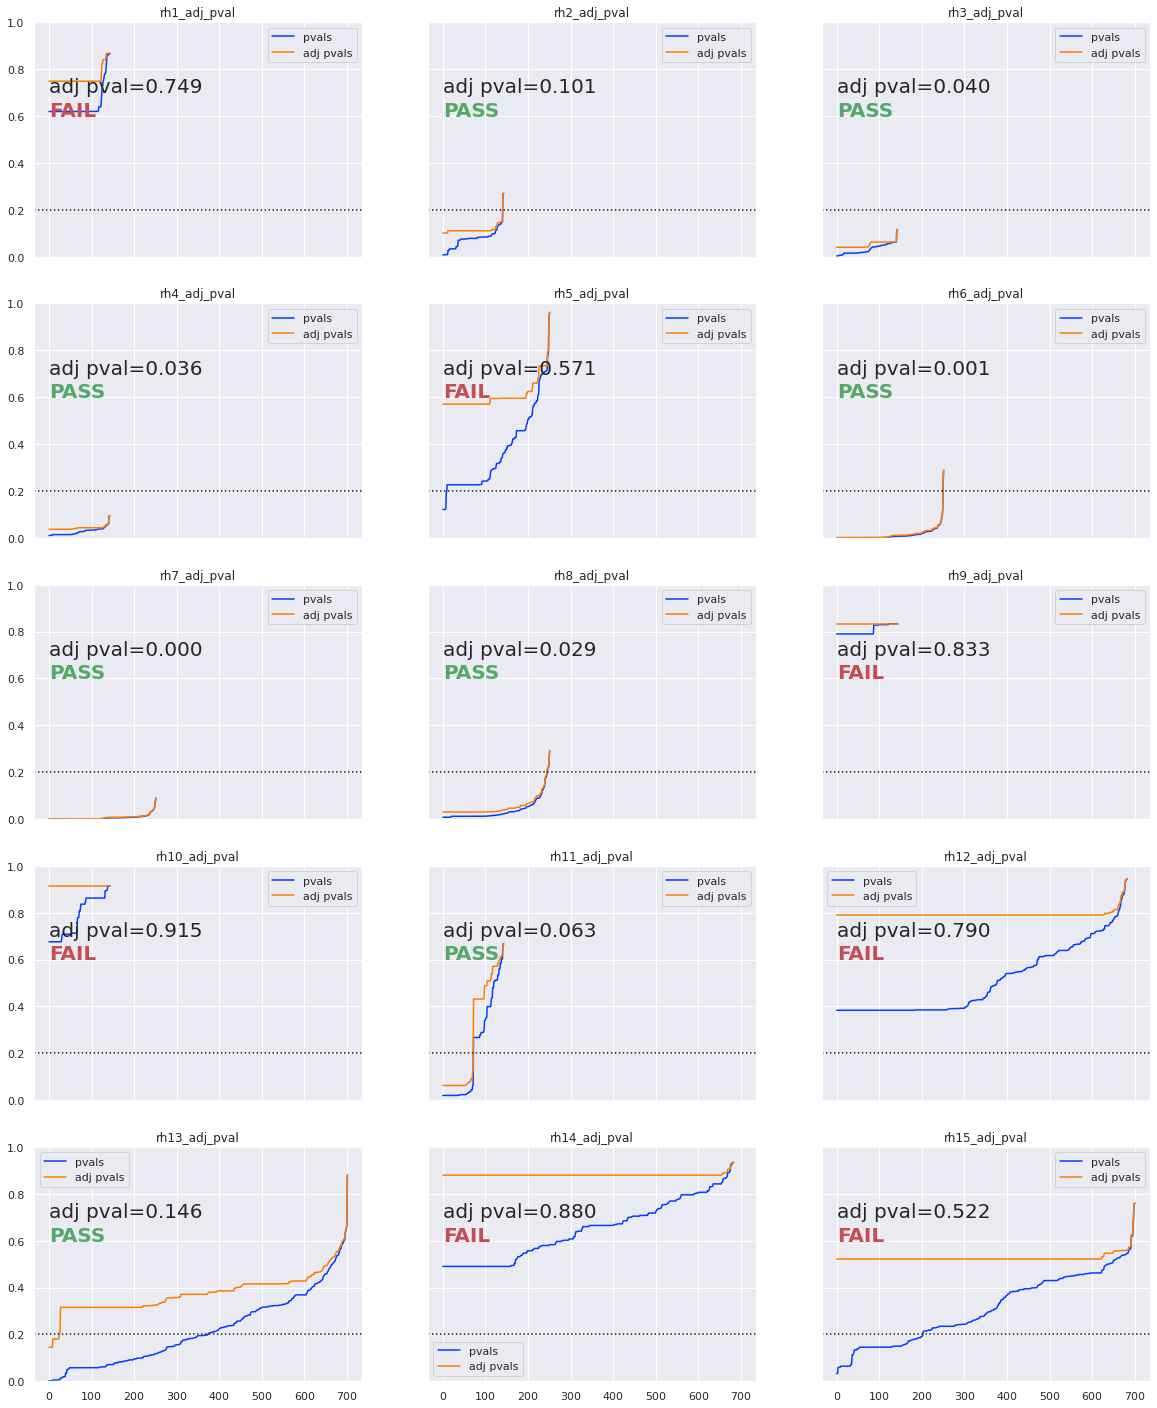

In [28]:
plot.multipletests_plot(
    results_df[adj_cols],
    threshold=eval_config["global_adj_pval_threshold"],
    num_cols=3
)

## Plot selected PnL

In [23]:
selected = amlnut.perform_family_selection(
    results_df, pnls, **eval_config["perform_family_selection"].to_dict()
)

No data remaining after filtering.
No data remaining after filtering.
No data remaining after filtering.
No data remaining after filtering.
No data remaining after filtering.


In [24]:
selected.keys()

dict_keys(['rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8', 'rh11', 'rh13', 'rh15'])

In [25]:
# TODO(2752): Make these fancy.
#
# for tag in selected.keys():
#    selected[tag].cumsum().plot()